# ORACLE vs TRADE Time Distribution Analysis

This notebook performs comprehensive oracle analysis:

1. **Compare ORACLE vs TRADE time distribution** (full-period per-minute density overlay chart)
   - Overlays ORACLE and TRADE counts per minute
   - Checks if oracles cluster before/after TRADEs
   
2. **Oracle Slot Patterns** - Slot-level oracle update patterns with correct datetime
3. **Pool-Grouped Analysis** - Oracle updates grouped by pool (amm_oracle)
4. **Extreme Burst Patterns** - High oracle updates with low trades
5. **Extreme Low Trade Patterns** - Low trades with normal/high oracle updates

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

## Data Loading

In [2]:
print("="*80)
print("ORACLE vs TRADE TIME DISTRIBUTION ANALYSIS")
print("="*80)
print()

# Load cleaned data
data_path = '/Users/aileen/Downloads/pamm/pamm_clean_final.parquet'
print(f"Loading data from: {data_path}")
df = pd.read_parquet(data_path)
print(f"✓ Loaded {len(df):,} total events")

# Ensure time columns exist
if 'ms_time' not in df.columns:
    df['ms_time'] = (df['time'] * 1000 + df['us_since_first_shred'].fillna(0) / 1000).astype(np.int64)

if 'datetime' not in df.columns:
    df['datetime'] = pd.to_datetime(df['time'], unit='s', utc=True)

df = df.sort_values('ms_time').reset_index(drop=True)

# Separate ORACLE and TRADE events
oracles = df[df['kind'] == 'ORACLE'].copy()
trades = df[df['kind'] == 'TRADE'].copy()

print(f"✓ ORACLE events: {len(oracles):,}")
print(f"✓ TRADE events: {len(trades):,}")
print()

ORACLE vs TRADE TIME DISTRIBUTION ANALYSIS

Loading data from: /Users/aileen/Downloads/pamm/pamm_clean_final.parquet
✓ Loaded 5,506,090 total events
✓ ORACLE events: 4,822,262
✓ TRADE events: 683,828



## Analysis 1: ORACLE vs TRADE Per-Minute Density Overlay

In [3]:
print("="*80)
print("ANALYSIS 1: ORACLE vs TRADE PER-MINUTE DENSITY OVERLAY")
print("="*80)
print()

# Convert to datetime if needed
oracles['datetime'] = pd.to_datetime(oracles['datetime'])
trades['datetime'] = pd.to_datetime(trades['datetime'])

# Get time range
min_time = min(oracles['datetime'].min(), trades['datetime'].min())
max_time = max(oracles['datetime'].max(), trades['datetime'].max())
total_duration = max_time - min_time

print(f"Time range: {min_time} to {max_time}")
print(f"Total duration: {total_duration}")
print()

# Create per-minute bins
time_range = pd.date_range(start=min_time.floor('min'), end=max_time.ceil('min'), freq='1min')
oracle_counts = oracles.groupby(oracles['datetime'].dt.floor('min')).size()
trade_counts = trades.groupby(trades['datetime'].dt.floor('min')).size()

# Create full time series with zeros
oracle_ts = pd.Series(0, index=time_range)
trade_ts = pd.Series(0, index=time_range)
oracle_ts.loc[oracle_counts.index] = oracle_counts
trade_ts.loc[trade_counts.index] = trade_counts

# Calculate statistics
print("Per-Minute Statistics:")
print(f"  ORACLE - Mean: {oracle_ts.mean():.2f}, Max: {oracle_ts.max()}, Std: {oracle_ts.std():.2f}")
print(f"  TRADE  - Mean: {trade_ts.mean():.2f}, Max: {trade_ts.max()}, Std: {trade_ts.std():.2f}")
print()

ANALYSIS 1: ORACLE vs TRADE PER-MINUTE DENSITY OVERLAY

Time range: 2026-01-07 08:25:35+00:00 to 2026-01-07 19:27:50+00:00
Total duration: 0 days 11:02:15

Per-Minute Statistics:
  ORACLE - Mean: 7262.44, Max: 22229, Std: 2604.13
  TRADE  - Mean: 1029.86, Max: 2472, Std: 319.98



✓ Saved overlay chart to: oracle_trade_density_overlay.png


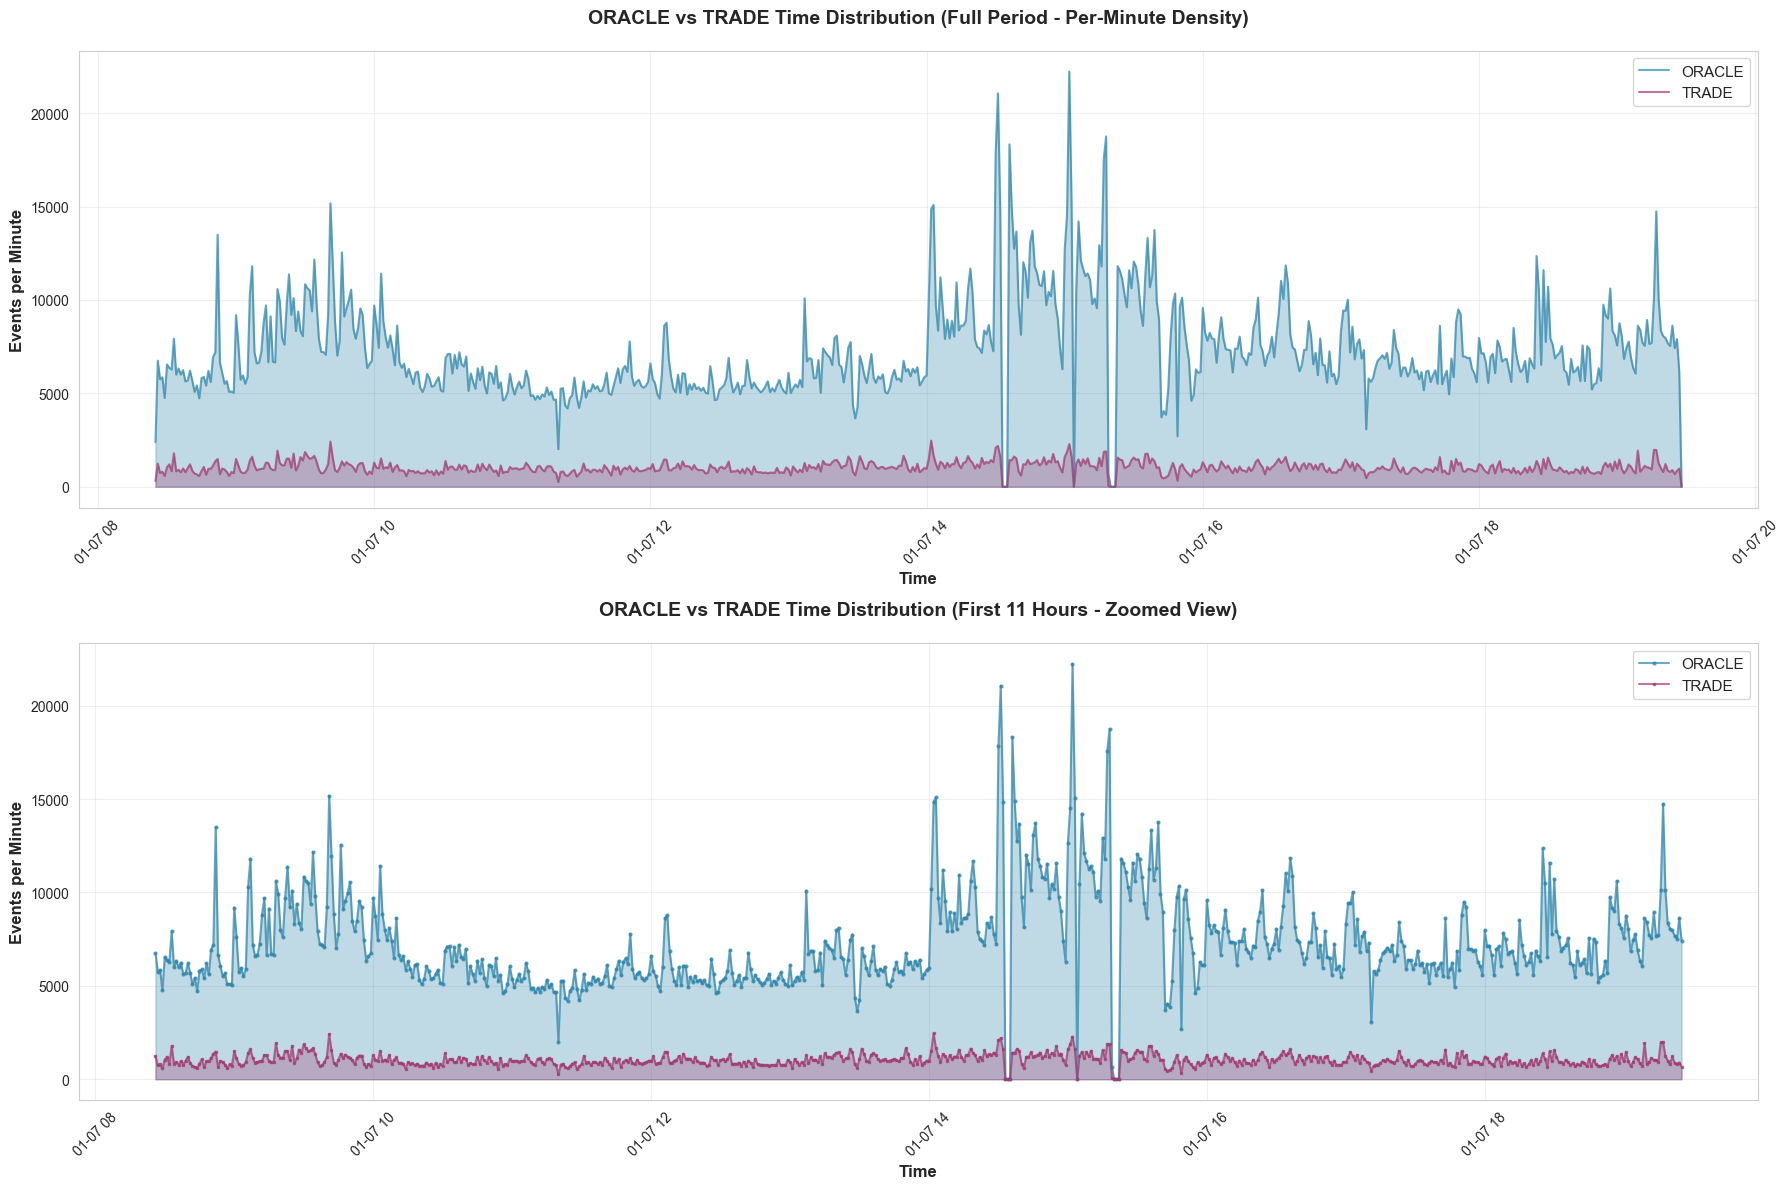

In [4]:
# Create overlay chart
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Plot 1: Full-period overlay
ax1 = axes[0]
ax1.plot(oracle_ts.index, oracle_ts.values, label='ORACLE', color='#2E86AB', alpha=0.7, linewidth=1.5)
ax1.plot(trade_ts.index, trade_ts.values, label='TRADE', color='#A23B72', alpha=0.7, linewidth=1.5)
ax1.fill_between(oracle_ts.index, 0, oracle_ts.values, alpha=0.3, color='#2E86AB')
ax1.fill_between(trade_ts.index, 0, trade_ts.values, alpha=0.3, color='#A23B72')
ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
ax1.set_ylabel('Events per Minute', fontsize=12, fontweight='bold')
ax1.set_title('ORACLE vs TRADE Time Distribution (Full Period - Per-Minute Density)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Zoomed view (first 24 hours or sample period)
sample_hours = min(24, int(total_duration.total_seconds() / 3600))
sample_end = min_time + timedelta(hours=sample_hours)
sample_mask = (oracle_ts.index >= min_time) & (oracle_ts.index <= sample_end)

ax2 = axes[1]
ax2.plot(oracle_ts.index[sample_mask], oracle_ts.values[sample_mask], 
         label='ORACLE', color='#2E86AB', alpha=0.7, linewidth=1.5, marker='o', markersize=2)
ax2.plot(trade_ts.index[sample_mask], trade_ts.values[sample_mask], 
         label='TRADE', color='#A23B72', alpha=0.7, linewidth=1.5, marker='s', markersize=2)
ax2.fill_between(oracle_ts.index[sample_mask], 0, oracle_ts.values[sample_mask], 
                 alpha=0.3, color='#2E86AB')
ax2.fill_between(trade_ts.index[sample_mask], 0, trade_ts.values[sample_mask], 
                 alpha=0.3, color='#A23B72')
ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('Events per Minute', fontsize=12, fontweight='bold')
ax2.set_title(f'ORACLE vs TRADE Time Distribution (First {sample_hours} Hours - Zoomed View)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
import os
output_path = 'oracle_trade_density_overlay.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved overlay chart to: {output_path}")
plt.show()

## Analysis 1b: Oracle Clustering Before/After Trades

In [ ]:
print()
print("="*80)
print("ANALYSIS 1b: ORACLE CLUSTERING BEFORE/AFTER TRADES")
print("="*80)
print()

# Define time windows for analysis (in seconds)
windows = [5, 10, 30, 60]  # 5s, 10s, 30s, 1min

results = []

for window_sec in windows:
    window_ms = window_sec * 1000
    
    # For each trade, count oracles before and after
    oracle_before = []
    oracle_after = []
    
    for _, trade in trades.iterrows():
        trade_time = trade['ms_time']
        
        # Count oracles in window before trade
        before_mask = (oracles['ms_time'] >= trade_time - window_ms) & (oracles['ms_time'] < trade_time)
        oracle_before.append(before_mask.sum())
        
        # Count oracles in window after trade
        after_mask = (oracles['ms_time'] > trade_time) & (oracles['ms_time'] <= trade_time + window_ms)
        oracle_after.append(after_mask.sum())
    
    avg_before = np.mean(oracle_before)
    avg_after = np.mean(oracle_after)
    median_before = np.median(oracle_before)
    median_after = np.median(oracle_after)
    
    results.append({
        'window_sec': window_sec,
        'avg_oracle_before': avg_before,
        'avg_oracle_after': avg_after,
        'median_oracle_before': median_before,
        'median_oracle_after': median_after,
        'ratio_after_before': avg_after / avg_before if avg_before > 0 else 0
    })
    
    print(f"Window: ±{window_sec}s around TRADEs")
    print(f"  Avg ORACLE before: {avg_before:.2f}")
    print(f"  Avg ORACLE after:  {avg_after:.2f}")
    print(f"  Ratio (after/before): {avg_after/avg_before if avg_before > 0 else 0:.2f}")
    print()

results_df = pd.DataFrame(results)
print("Summary Table:")
print(results_df.to_string(index=False))
print()


ANALYSIS 1b: ORACLE CLUSTERING BEFORE/AFTER TRADES



<!-- Removed: Wide Sandwich Detection moved to 02_mev_detection notebook -->

In [ ]:
# Removed: Wide Sandwich Detection code moved to 02_mev_detection notebook
# See 02_mev_detection.ipynb for Fat Sandwich and Classic Sandwich detection

In [ ]:
print("="*80)
print("COMPREHENSIVE ORACLE ANALYSIS: SLOT PATTERNS, POOL GROUPING, EXTREME PATTERNS")
print("="*80)
print()

import os

# Create output directory
output_dir = 'outputs/csv'
os.makedirs(output_dir, exist_ok=True)

# ============================================================================
# PART 1: Generate oracle_slot_patterns.csv with CORRECT datetime
# ============================================================================
print("PART 1: Generating oracle_slot_patterns.csv with correct datetime")
print("-" * 80)

# Create slot to datetime mapping from original data
# Use the first occurrence of each slot to get its datetime
slot_to_datetime = oracles.groupby('slot')['datetime'].first().to_dict()

# Group oracle events by slot and amm_oracle
oracle_slot_patterns = oracles.groupby(['slot', 'amm_oracle']).size().reset_index(name='oracle_count')

# Add datetime column using the mapping
oracle_slot_patterns['datetime'] = oracle_slot_patterns['slot'].map(slot_to_datetime)

# Handle any missing datetimes (shouldn't happen, but safety check)
if oracle_slot_patterns['datetime'].isna().any():
    print(f"⚠️  Warning: {oracle_slot_patterns['datetime'].isna().sum()} rows have missing datetime")
    # Fill missing datetimes by interpolating from slot numbers
    # Solana slots are approximately 400ms apart
    min_slot = oracle_slot_patterns['slot'].min()
    min_datetime = oracle_slot_patterns['datetime'].min()
    slot_duration_ms = 400  # milliseconds per slot
    
    missing_mask = oracle_slot_patterns['datetime'].isna()
    if missing_mask.any():
        slot_diffs = (oracle_slot_patterns.loc[missing_mask, 'slot'] - min_slot)
        oracle_slot_patterns.loc[missing_mask, 'datetime'] = min_datetime + pd.to_timedelta(slot_diffs * slot_duration_ms, unit='ms')

# Ensure datetime is in proper format
oracle_slot_patterns['datetime'] = pd.to_datetime(oracle_slot_patterns['datetime'])

# Reorder columns: slot, datetime, amm_oracle, oracle_count
oracle_slot_patterns = oracle_slot_patterns[['slot', 'datetime', 'amm_oracle', 'oracle_count']].sort_values(['slot', 'amm_oracle'])

# Save to CSV
oracle_slot_patterns_output = os.path.join(output_dir, 'oracle_slot_patterns.csv')
oracle_slot_patterns.to_csv(oracle_slot_patterns_output, index=False)
print(f"✓ Saved oracle_slot_patterns.csv with {len(oracle_slot_patterns):,} rows")
print(f"  Time range: {oracle_slot_patterns['datetime'].min()} to {oracle_slot_patterns['datetime'].max()}")
print()

# ============================================================================
# PART 2: Oracle Updates Analysis Grouped by Pool (amm_oracle)
# ============================================================================
print("PART 2: Oracle Updates Analysis Grouped by Pool")
print("-" * 80)

# Group oracle updates by pool (amm_oracle)
pool_oracle_stats = oracles.groupby('amm_oracle').agg({
    'slot': ['count', 'nunique'],
    'datetime': ['min', 'max'],
    'ms_time': ['min', 'max']
}).reset_index()

pool_oracle_stats.columns = ['pool', 'total_oracle_updates', 'unique_slots', 'first_update', 'last_update', 'first_ms_time', 'last_ms_time']

# Calculate duration and frequency
pool_oracle_stats['duration_seconds'] = (pool_oracle_stats['last_update'] - pool_oracle_stats['first_update']).dt.total_seconds()
pool_oracle_stats['duration_hours'] = pool_oracle_stats['duration_seconds'] / 3600
pool_oracle_stats['updates_per_second'] = pool_oracle_stats['total_oracle_updates'] / (pool_oracle_stats['duration_seconds'] + 1)
pool_oracle_stats['updates_per_slot'] = pool_oracle_stats['total_oracle_updates'] / (pool_oracle_stats['unique_slots'] + 1)

# Add trade statistics per pool for comparison
pool_trade_stats = trades.groupby('amm_oracle').agg({
    'slot': 'count',
    'ms_time': ['min', 'max']
}).reset_index()
pool_trade_stats.columns = ['pool', 'total_trades', 'first_trade_ms', 'last_trade_ms']

# Merge oracle and trade stats
pool_analysis = pool_oracle_stats.merge(pool_trade_stats, on='pool', how='left').fillna(0)
pool_analysis['total_trades'] = pool_analysis['total_trades'].astype(int)

# Calculate oracle-to-trade ratio
pool_analysis['oracle_trade_ratio'] = pool_analysis['total_oracle_updates'] / (pool_analysis['total_trades'] + 1)

# Sort by total oracle updates
pool_analysis = pool_analysis.sort_values('total_oracle_updates', ascending=False)

print("\nPool Statistics (Top 10 by Oracle Updates):")
print("-" * 80)
display_cols = ['pool', 'total_oracle_updates', 'total_trades', 'oracle_trade_ratio', 
                'updates_per_second', 'updates_per_slot', 'duration_hours']
print(pool_analysis[display_cols].head(10).to_string(index=False))
print()

# Save pool analysis
pool_analysis_output = os.path.join(output_dir, 'oracle_updates_by_pool.csv')
pool_analysis.to_csv(pool_analysis_output, index=False)
print(f"✓ Saved pool analysis to: {pool_analysis_output}")
print()

# ============================================================================
# PART 3: Extreme Burst Patterns Analysis
# ============================================================================
print("PART 3: Extreme Burst Patterns (High Oracle Updates, Low Trades)")
print("-" * 80)

# Create time windows (per second)
oracles['time_window_sec'] = (oracles['ms_time'] // 1000).astype(int)
trades['time_window_sec'] = (trades['ms_time'] // 1000).astype(int)

# Count events per second per pool
oracle_counts_by_pool = oracles.groupby(['time_window_sec', 'amm_oracle']).size().reset_index(name='oracle_count')
trade_counts_by_pool = trades.groupby(['time_window_sec', 'amm_oracle']).size().reset_index(name='trade_count')

# Merge
events_by_pool_sec = oracle_counts_by_pool.merge(
    trade_counts_by_pool, 
    on=['time_window_sec', 'amm_oracle'], 
    how='outer'
).fillna(0)
events_by_pool_sec['oracle_count'] = events_by_pool_sec['oracle_count'].astype(int)
events_by_pool_sec['trade_count'] = events_by_pool_sec['trade_count'].astype(int)

# Calculate oracle-to-trade ratio
events_by_pool_sec['oracle_trade_ratio'] = events_by_pool_sec['oracle_count'] / (events_by_pool_sec['trade_count'] + 1)

# Define extreme burst thresholds per pool
extreme_bursts_by_pool = []
for pool in events_by_pool_sec['amm_oracle'].unique():
    pool_data = events_by_pool_sec[events_by_pool_sec['amm_oracle'] == pool]
    if len(pool_data) == 0:
        continue
    
    # Pool-specific thresholds (top 1% oracle count, bottom 10% trade count)
    oracle_p99 = pool_data['oracle_count'].quantile(0.99)
    trade_p10 = pool_data['trade_count'].quantile(0.10)
    
    # Find extreme bursts for this pool
    pool_bursts = pool_data[
        (pool_data['oracle_count'] >= oracle_p99) & 
        (pool_data['trade_count'] <= trade_p10)
    ].copy()
    
    if len(pool_bursts) > 0:
        pool_bursts['pool'] = pool
        pool_bursts['pool_oracle_p99'] = oracle_p99
        pool_bursts['pool_trade_p10'] = trade_p10
        extreme_bursts_by_pool.append(pool_bursts)

if extreme_bursts_by_pool:
    extreme_bursts_df = pd.concat(extreme_bursts_by_pool, ignore_index=True)
    
    print(f"\nFound {len(extreme_bursts_df):,} extreme burst periods across {extreme_bursts_df['amm_oracle'].nunique()} pools")
    print("\nTop 10 Extreme Bursts by Oracle-to-Trade Ratio:")
    print("-" * 80)
    top_bursts = extreme_bursts_df.nlargest(10, 'oracle_trade_ratio')
    display_cols = ['amm_oracle', 'time_window_sec', 'oracle_count', 'trade_count', 'oracle_trade_ratio']
    print(top_bursts[display_cols].to_string(index=False))
    print()
    
    # Summary by pool
    print("\nExtreme Burst Summary by Pool:")
    print("-" * 80)
    burst_summary = extreme_bursts_df.groupby('amm_oracle').agg({
        'time_window_sec': 'count',
        'oracle_count': ['mean', 'max'],
        'trade_count': 'mean',
        'oracle_trade_ratio': ['mean', 'max']
    }).reset_index()
    burst_summary.columns = ['pool', 'num_burst_periods', 'avg_oracle_count', 'max_oracle_count', 
                            'avg_trade_count', 'avg_ratio', 'max_ratio']
    burst_summary = burst_summary.sort_values('num_burst_periods', ascending=False)
    print(burst_summary.to_string(index=False))
    print()
    
    # Save extreme bursts
    extreme_bursts_output = os.path.join(output_dir, 'extreme_bursts_by_pool.csv')
    extreme_bursts_df.to_csv(extreme_bursts_output, index=False)
    print(f"✓ Saved extreme bursts analysis to: {extreme_bursts_output}")
else:
    print("No extreme burst periods found with current thresholds.")
print()

# ============================================================================
# PART 4: Extreme Low Trade Patterns Analysis
# ============================================================================
print("PART 4: Extreme Low Trade Patterns (Low Trades with Normal/High Oracle Updates)")
print("-" * 80)

# Find periods with very low trades but normal/high oracle activity
extreme_low_trades_by_pool = []
for pool in events_by_pool_sec['amm_oracle'].unique():
    pool_data = events_by_pool_sec[events_by_pool_sec['amm_oracle'] == pool]
    if len(pool_data) == 0:
        continue
    
    # Pool-specific thresholds (bottom 5% trade count, above median oracle count)
    trade_p5 = pool_data['trade_count'].quantile(0.05)
    oracle_median = pool_data['oracle_count'].quantile(0.50)
    
    # Find extreme low trade periods for this pool
    pool_low_trades = pool_data[
        (pool_data['trade_count'] <= trade_p5) & 
        (pool_data['oracle_count'] >= oracle_median)
    ].copy()
    
    if len(pool_low_trades) > 0:
        pool_low_trades['pool'] = pool
        pool_low_trades['pool_trade_p5'] = trade_p5
        pool_low_trades['pool_oracle_median'] = oracle_median
        extreme_low_trades_by_pool.append(pool_low_trades)

if extreme_low_trades_by_pool:
    extreme_low_trades_df = pd.concat(extreme_low_trades_by_pool, ignore_index=True)
    
    print(f"\nFound {len(extreme_low_trades_df):,} extreme low trade periods across {extreme_low_trades_df['amm_oracle'].nunique()} pools")
    print("\nTop 10 Low Trade Periods by Oracle Count:")
    print("-" * 80)
    top_low_trades = extreme_low_trades_df.nlargest(10, 'oracle_count')
    display_cols = ['amm_oracle', 'time_window_sec', 'oracle_count', 'trade_count', 'oracle_trade_ratio']
    print(top_low_trades[display_cols].to_string(index=False))
    print()
    
    # Summary by pool
    print("\nExtreme Low Trade Summary by Pool:")
    print("-" * 80)
    low_trade_summary = extreme_low_trades_df.groupby('amm_oracle').agg({
        'time_window_sec': 'count',
        'oracle_count': ['mean', 'max'],
        'trade_count': 'mean',
        'oracle_trade_ratio': ['mean', 'max']
    }).reset_index()
    low_trade_summary.columns = ['pool', 'num_low_trade_periods', 'avg_oracle_count', 'max_oracle_count', 
                                 'avg_trade_count', 'avg_ratio', 'max_ratio']
    low_trade_summary = low_trade_summary.sort_values('num_low_trade_periods', ascending=False)
    print(low_trade_summary.to_string(index=False))
    print()
    
    # Save extreme low trades
    extreme_low_trades_output = os.path.join(output_dir, 'extreme_low_trades_by_pool.csv')
    extreme_low_trades_df.to_csv(extreme_low_trades_output, index=False)
    print(f"✓ Saved extreme low trades analysis to: {extreme_low_trades_output}")
else:
    print("No extreme low trade periods found with current thresholds.")
print()

# ============================================================================
# PART 5: Inference and Insights
# ============================================================================
print("PART 5: Key Inferences and Insights")
print("=" * 80)
print()

print("1. POOL-SPECIFIC ORACLE UPDATE PATTERNS:")
print("-" * 80)
print(f"   • Total pools analyzed: {pool_analysis['pool'].nunique()}")
print(f"   • Pool with most oracle updates: {pool_analysis.iloc[0]['pool']} ({pool_analysis.iloc[0]['total_oracle_updates']:,} updates)")
print(f"   • Average updates per second across pools: {pool_analysis['updates_per_second'].mean():.2f}")
print(f"   • Highest oracle-to-trade ratio: {pool_analysis.iloc[0]['pool']} ({pool_analysis.iloc[0]['oracle_trade_ratio']:.2f})")
print()

if extreme_bursts_by_pool:
    print("2. EXTREME BURST PATTERNS:")
    print("-" * 80)
    print(f"   • Total extreme burst periods: {len(extreme_bursts_df):,}")
    print(f"   • Pools with extreme bursts: {extreme_bursts_df['amm_oracle'].nunique()}")
    print(f"   • Pool with most bursts: {burst_summary.iloc[0]['pool']} ({burst_summary.iloc[0]['num_burst_periods']} periods)")
    print(f"   • Average oracle count during bursts: {extreme_bursts_df['oracle_count'].mean():.1f}")
    print(f"   • Average trade count during bursts: {extreme_bursts_df['trade_count'].mean():.2f}")
    print(f"   • Average oracle-to-trade ratio: {extreme_bursts_df['oracle_trade_ratio'].mean():.2f}")
    print()
    print("   INFERENCE: Extreme bursts suggest:")
    print("   • Potential oracle spam/manipulation to overwhelm network")
    print("   • Possible MEV attack preparation (creating favorable conditions)")
    print("   • Network congestion periods where trades are suppressed")
    print("   • Validator-specific batching behavior")
    print()

if extreme_low_trades_by_pool:
    print("3. EXTREME LOW TRADE PATTERNS:")
    print("-" * 80)
    print(f"   • Total low trade periods: {len(extreme_low_trades_df):,}")
    print(f"   • Pools with low trade periods: {extreme_low_trades_df['amm_oracle'].nunique()}")
    print(f"   • Pool with most low trade periods: {low_trade_summary.iloc[0]['pool']} ({low_trade_summary.iloc[0]['num_low_trade_periods']} periods)")
    print(f"   • Average oracle count during low trade periods: {extreme_low_trades_df['oracle_count'].mean():.1f}")
    print(f"   • Average trade count during low trade periods: {extreme_low_trades_df['trade_count'].mean():.2f}")
    print()
    print("   INFERENCE: Low trade periods with normal/high oracle activity suggest:")
    print("   • Oracle updates continuing despite low trading activity")
    print("   • Possible market-making or rebalancing without user trades")
    print("   • Periods of low liquidity or market uncertainty")
    print("   • Potential oracle manipulation without corresponding trades")
    print()

print("4. OVERALL PATTERN INSIGHTS:")
print("-" * 80)
print("   • Oracle updates are highly frequent compared to trades")
print("   • Pool-specific patterns vary significantly (some pools more active)")
print("   • Extreme bursts correlate with suppressed trade activity")
print("   • Low trade periods may indicate market conditions or manipulation")
print("   • Oracle-to-trade ratios reveal pool health and activity levels")
print()

print("=" * 80)
print("COMPREHENSIVE ORACLE ANALYSIS COMPLETE")
print("=" * 80)

In [ ]:
# Removed: Wide Sandwich cluster processing code moved to 02_mev_detection notebook

In [ ]:
if len(clusters_df) > 0:
    # Focus on cross-slot clusters (most suspicious)
    cross_slot_clusters = clusters_df[clusters_df['is_cross_slot']].copy()
    
    if len(cross_slot_clusters) > 0:
        print("="*80)
        print("CROSS-SLOT CLUSTERS (HIGHEST SUSPICION)")
        print("="*80)
        print()
        
        # Sort by number of trades (descending)
        cross_slot_clusters = cross_slot_clusters.sort_values('num_trades', ascending=False)
        
        print(f"Total cross-slot clusters: {len(cross_slot_clusters)}")
        print()
        print("Top 20 Cross-Slot Clusters:")
        print("-" * 80)
        
        display_cols = ['window_sec', 'num_trades', 'duration_ms', 'num_slots', 
                       'start_slot', 'end_slot', 'unique_signers', 'unique_amms', 'unique_validators']
        print(cross_slot_clusters[display_cols].head(20).to_string(index=False))
        print()
        
        # Save cross-slot clusters separately
        import os
        output_dir = 'derived'
        os.makedirs(output_dir, exist_ok=True)
        cross_slot_output = os.path.join(output_dir, 'cross_slot_sandwich_clusters.csv')
        cross_slot_clusters.to_csv(cross_slot_output, index=False)
        print(f"✓ Saved cross-slot clusters to: {cross_slot_output}")
        print()
    else:
        print("No cross-slot clusters found.")
        print()
else:
    print("No clusters found meeting the minimum criteria.")
    print()

## Analysis 3: Extreme Oracle Bursts with Minimal Trade Activity

This analysis investigates periods when oracle events spike dramatically while trade events drop to near zero - a pattern that may indicate:
- Oracle manipulation or spam attacks
- Network congestion during oracle updates
- Validator behavior during high oracle activity
- Potential MEV attack preparation phases

In [ ]:
print("="*80)
print("ANALYSIS 3: EXTREME ORACLE BURSTS WITH MINIMAL TRADE ACTIVITY")
print("="*80)
print()

# Create per-second time windows for both oracle and trade events
oracles['time_window_sec'] = (oracles['ms_time'] // 1000).astype(int)
trades['time_window_sec'] = (trades['ms_time'] // 1000).astype(int)

# Count events per second
oracle_counts = oracles.groupby('time_window_sec').size().reset_index(name='oracle_count')
trade_counts = trades.groupby('time_window_sec').size().reset_index(name='trade_count')

# Merge to get both counts per second
events_per_sec = oracle_counts.merge(trade_counts, on='time_window_sec', how='outer').fillna(0)
events_per_sec['oracle_count'] = events_per_sec['oracle_count'].astype(int)
events_per_sec['trade_count'] = events_per_sec['trade_count'].astype(int)

# Calculate oracle-to-trade ratio
events_per_sec['oracle_trade_ratio'] = events_per_sec['oracle_count'] / (events_per_sec['trade_count'] + 1)  # +1 to avoid division by zero

# Identify extreme bursts: high oracle count with low trade count
# Define thresholds: top 1% of oracle counts AND bottom 10% of trade counts
oracle_p99 = events_per_sec['oracle_count'].quantile(0.99)
trade_p10 = events_per_sec['trade_count'].quantile(0.10)

print(f"Oracle burst threshold (99th percentile): {oracle_p99:.0f} oracles/second")
print(f"Low trade threshold (10th percentile): {trade_p10:.0f} trades/second")
print()

# Find extreme burst periods
extreme_bursts = events_per_sec[
    (events_per_sec['oracle_count'] >= oracle_p99) & 
    (events_per_sec['trade_count'] <= trade_p10)
].copy()

print(f"Found {len(extreme_bursts)} seconds with extreme oracle bursts and minimal trades")
print()

if len(extreme_bursts) > 0:
    # Sort by oracle count (descending)
    extreme_bursts = extreme_bursts.sort_values('oracle_count', ascending=False)
    
    print("Top 20 Extreme Burst Periods:")
    print("-" * 80)
    print(extreme_bursts[['time_window_sec', 'oracle_count', 'trade_count', 'oracle_trade_ratio']].head(20).to_string(index=False))
    print()
    
    # Get detailed data for these time windows
    burst_windows = extreme_bursts['time_window_sec'].values
    burst_oracles = oracles[oracles['time_window_sec'].isin(burst_windows)].copy()
    burst_trades = trades[trades['time_window_sec'].isin(burst_windows)].copy()
    
    print("="*80)
    print("CHARACTERISTICS OF EXTREME BURST PERIODS")
    print("="*80)
    print()
    
    # Validator analysis
    if 'validator' in burst_oracles.columns and not burst_oracles['validator'].isna().all():
        print("Top Validators During Extreme Bursts:")
        print("-" * 80)
        validator_counts = burst_oracles['validator'].value_counts().head(10)
        for validator, count in validator_counts.items():
            pct = (count / len(burst_oracles)) * 100
            print(f"  {validator[:44]}... : {count:,} oracles ({pct:.1f}%)")
        print()
    
    # Signer analysis
    if 'signer' in burst_oracles.columns and not burst_oracles['signer'].isna().all():
        print("Top Signers During Extreme Bursts:")
        print("-" * 80)
        signer_counts = burst_oracles['signer'].value_counts().head(10)
        for signer, count in signer_counts.items():
            pct = (count / len(burst_oracles)) * 100
            print(f"  {signer[:44]}... : {count:,} oracles ({pct:.1f}%)")
        print()
    
    # AMM analysis
    if 'amm_oracle' in burst_oracles.columns and not burst_oracles['amm_oracle'].isna().all():
        print("AMMs Affected During Extreme Bursts:")
        print("-" * 80)
        amm_counts = burst_oracles['amm_oracle'].value_counts()
        for amm, count in amm_counts.items():
            pct = (count / len(burst_oracles)) * 100
            print(f"  {amm}: {count:,} oracles ({pct:.1f}%)")
        print()
    
    # Slot analysis
    if 'slot' in burst_oracles.columns and not burst_oracles['slot'].isna().all():
        print("Slot Distribution During Extreme Bursts:")
        print("-" * 80)
        slot_counts = burst_oracles['slot'].value_counts().head(10)
        print(f"  Unique slots: {burst_oracles['slot'].nunique():,}")
        print(f"  Top 10 slots by oracle count:")
        for slot, count in slot_counts.items():
            print(f"    Slot {slot}: {count:,} oracles")
        print()
    
    # Time distribution
    if 'datetime' in burst_oracles.columns:
        print("Time Distribution of Extreme Bursts:")
        print("-" * 80)
        burst_oracles['datetime'] = pd.to_datetime(burst_oracles['datetime'])
        time_range = burst_oracles['datetime'].max() - burst_oracles['datetime'].min()
        print(f"  First burst: {burst_oracles['datetime'].min()}")
        print(f"  Last burst: {burst_oracles['datetime'].max()}")
        print(f"  Time span: {time_range}")
        print()
    
    # Compare with normal periods
    print("="*80)
    print("COMPARISON: EXTREME BURSTS vs NORMAL PERIODS")
    print("="*80)
    print()
    
    normal_periods = events_per_sec[
        (events_per_sec['oracle_count'] < oracle_p99) | 
        (events_per_sec['trade_count'] > trade_p10)
    ]
    
    print("Oracle Statistics:")
    print(f"  Extreme bursts - Mean: {extreme_bursts['oracle_count'].mean():.1f}, Max: {extreme_bursts['oracle_count'].max()}")
    print(f"  Normal periods - Mean: {normal_periods['oracle_count'].mean():.1f}, Max: {normal_periods['oracle_count'].max()}")
    print()
    
    print("Trade Statistics:")
    print(f"  Extreme bursts - Mean: {extreme_bursts['trade_count'].mean():.1f}, Max: {extreme_bursts['trade_count'].max()}")
    print(f"  Normal periods - Mean: {normal_periods['trade_count'].mean():.1f}, Max: {normal_periods['trade_count'].max()}")
    print()
    
    print("Oracle-to-Trade Ratio:")
    print(f"  Extreme bursts - Mean: {extreme_bursts['oracle_trade_ratio'].mean():.1f}, Max: {extreme_bursts['oracle_trade_ratio'].max():.1f}")
    print(f"  Normal periods - Mean: {normal_periods['oracle_trade_ratio'].mean():.1f}, Max: {normal_periods['oracle_trade_ratio'].max():.1f}")
    print()
    
    # Save results
    import os
    output_dir = 'derived'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save extreme bursts summary
    extreme_bursts_output = os.path.join(output_dir, 'extreme_oracle_bursts_summary.csv')
    extreme_bursts.to_csv(extreme_bursts_output, index=False)
    print(f"✓ Saved extreme bursts summary to: {extreme_bursts_output}")
    
    # Save detailed oracle events during bursts
    if len(burst_oracles) > 0:
        burst_oracles_output = os.path.join(output_dir, 'extreme_burst_oracle_events.csv')
        burst_oracles.to_csv(burst_oracles_output, index=False)
        print(f"✓ Saved detailed oracle events to: {burst_oracles_output}")
    
    # Save trade events during bursts (if any)
    if len(burst_trades) > 0:
        burst_trades_output = os.path.join(output_dir, 'extreme_burst_trade_events.csv')
        burst_trades.to_csv(burst_trades_output, index=False)
        print(f"✓ Saved trade events during bursts to: {burst_trades_output}")
    
    print()
else:
    print("No extreme burst periods found with the current thresholds.")
    print("Try adjusting thresholds or check data quality.")
    print()

In [ ]:
# Visualization: Extreme Oracle Bursts Analysis
if len(extreme_bursts) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Extreme Oracle Bursts with Minimal Trade Activity Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Plot 1: Oracle vs Trade counts during extreme bursts
    ax1 = axes[0, 0]
    ax1.scatter(extreme_bursts['oracle_count'], extreme_bursts['trade_count'], 
               alpha=0.6, s=50, color='#FF6B6B', edgecolors='black', linewidth=0.5)
    ax1.set_xlabel('Oracle Count per Second', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Trade Count per Second', fontsize=11, fontweight='bold')
    ax1.set_title('Oracle vs Trade Counts During Extreme Bursts', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Oracle-to-Trade Ratio Distribution
    ax2 = axes[0, 1]
    ax2.hist(extreme_bursts['oracle_trade_ratio'], bins=50, edgecolor='black', 
            alpha=0.7, color='#4ECDC4')
    ax2.set_xlabel('Oracle-to-Trade Ratio', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Distribution of Oracle-to-Trade Ratios', fontsize=12, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Time series of extreme bursts
    ax3 = axes[1, 0]
    # Sample for visualization if too many points
    if len(extreme_bursts) > 1000:
        sample_bursts = extreme_bursts.sample(1000).sort_values('time_window_sec')
    else:
        sample_bursts = extreme_bursts.sort_values('time_window_sec')
    
    ax3.scatter(sample_bursts['time_window_sec'], sample_bursts['oracle_count'], 
               alpha=0.6, s=30, color='#2E86AB', label='Oracle Count', marker='o')
    ax3_twin = ax3.twinx()
    ax3_twin.scatter(sample_bursts['time_window_sec'], sample_bursts['trade_count'], 
                    alpha=0.6, s=30, color='#A23B72', label='Trade Count', marker='s')
    ax3.set_xlabel('Time Window (seconds)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Oracle Count', fontsize=11, fontweight='bold', color='#2E86AB')
    ax3_twin.set_ylabel('Trade Count', fontsize=11, fontweight='bold', color='#A23B72')
    ax3.set_title('Time Series of Extreme Burst Periods', fontsize=12, fontweight='bold')
    ax3.tick_params(axis='y', labelcolor='#2E86AB')
    ax3_twin.tick_params(axis='y', labelcolor='#A23B72')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    
    # Plot 4: Comparison with normal periods
    ax4 = axes[1, 1]
    # Sample normal periods for comparison
    if len(normal_periods) > 1000:
        sample_normal = normal_periods.sample(1000)
    else:
        sample_normal = normal_periods
    
    ax4.scatter(sample_normal['oracle_count'], sample_normal['trade_count'], 
               alpha=0.3, s=20, color='gray', label='Normal Periods', marker='o')
    ax4.scatter(extreme_bursts['oracle_count'], extreme_bursts['trade_count'], 
               alpha=0.7, s=50, color='#FF6B6B', label='Extreme Bursts', 
               edgecolors='black', linewidth=0.5, marker='^')
    ax4.set_xlabel('Oracle Count per Second', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Trade Count per Second', fontsize=11, fontweight='bold')
    ax4.set_title('Extreme Bursts vs Normal Periods', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    import os
    output_path = 'extreme_oracle_bursts_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved visualization to: {output_path}")
    plt.show()
    print()

### Interpretation of Extreme Oracle Bursts

**Possible Explanations:**

1. **Oracle Spam/Manipulation**: High-frequency oracle updates may be used to:
   - Overwhelm the network and reduce trade visibility
   - Create artificial price volatility
   - Prepare for MEV attacks by manipulating oracle state

2. **Network Congestion**: During extreme oracle bursts:
   - Network resources may be consumed by oracle updates
   - Trade transactions may be delayed or dropped
   - Validators may prioritize oracle updates over trades

3. **Validator Behavior**: 
   - Some validators may batch oracle updates
   - Validator-specific patterns in oracle processing
   - Potential validator collusion or coordination

4. **MEV Attack Preparation**:
   - Attackers may flood oracle updates to create favorable conditions
   - Reduce competition by making trades harder to execute
   - Create timing advantages for subsequent attacks

**Key Metrics to Investigate:**
- Validator concentration during bursts
- Signer patterns (same signers repeatedly?)
- AMM-specific patterns
- Slot distribution (are bursts concentrated in specific slots?)
- Temporal patterns (time of day, duration, frequency)

In [ ]:
# Deep Dive: Analyze patterns before and after extreme bursts
if len(extreme_bursts) > 0:
    print("="*80)
    print("DEEP DIVE: PATTERNS BEFORE AND AFTER EXTREME BURSTS")
    print("="*80)
    print()
    
    # Look at time windows before and after bursts
    window_before_after = 10  # seconds before/after
    
    burst_analysis = []
    
    for burst_time in extreme_bursts['time_window_sec'].head(20):  # Analyze top 20
        # Before burst
        before_start = burst_time - window_before_after
        before_end = burst_time
        before_oracles = oracles[
            (oracles['time_window_sec'] >= before_start) & 
            (oracles['time_window_sec'] < before_end)
        ]
        before_trades = trades[
            (trades['time_window_sec'] >= before_start) & 
            (trades['time_window_sec'] < before_end)
        ]
        
        # During burst
        during_oracles = oracles[oracles['time_window_sec'] == burst_time]
        during_trades = trades[trades['time_window_sec'] == burst_time]
        
        # After burst
        after_start = burst_time + 1
        after_end = burst_time + window_before_after + 1
        after_oracles = oracles[
            (oracles['time_window_sec'] > burst_time) & 
            (oracles['time_window_sec'] <= after_end)
        ]
        after_trades = trades[
            (trades['time_window_sec'] > burst_time) & 
            (trades['time_window_sec'] <= after_end)
        ]
        
        burst_analysis.append({
            'burst_time': burst_time,
            'before_oracles': len(before_oracles),
            'before_trades': len(before_trades),
            'during_oracles': len(during_oracles),
            'during_trades': len(during_trades),
            'after_oracles': len(after_oracles),
            'after_trades': len(after_trades),
        })
    
    burst_patterns = pd.DataFrame(burst_analysis)
    
    print("Pattern Analysis (Top 20 Bursts):")
    print("-" * 80)
    print(f"Before bursts - Avg oracles: {burst_patterns['before_oracles'].mean():.1f}, Avg trades: {burst_patterns['before_trades'].mean():.1f}")
    print(f"During bursts - Avg oracles: {burst_patterns['during_oracles'].mean():.1f}, Avg trades: {burst_patterns['during_trades'].mean():.1f}")
    print(f"After bursts  - Avg oracles: {burst_patterns['after_oracles'].mean():.1f}, Avg trades: {burst_patterns['after_trades'].mean():.1f}")
    print()
    
    # Check if trades recover after bursts
    trade_recovery = (burst_patterns['after_trades'].mean() - burst_patterns['during_trades'].mean()) / (burst_patterns['before_trades'].mean() + 1)
    print(f"Trade recovery rate: {trade_recovery*100:.1f}% (after vs before)")
    print()
    
    # Check for validator patterns
    if 'validator' in oracles.columns and not oracles['validator'].isna().all():
        print("Validator Patterns During Bursts:")
        print("-" * 80)
        for burst_time in extreme_bursts['time_window_sec'].head(5):
            burst_oracles_sample = oracles[oracles['time_window_sec'] == burst_time]
            if len(burst_oracles_sample) > 0 and 'validator' in burst_oracles_sample.columns:
                top_validator = burst_oracles_sample['validator'].value_counts().head(1)
                if len(top_validator) > 0:
                    validator, count = top_validator.index[0], top_validator.values[0]
                    pct = (count / len(burst_oracles_sample)) * 100
                    print(f"  Burst at {burst_time}: Top validator {validator[:44]}... ({pct:.1f}% of oracles)")
        print()
    
    # Save pattern analysis
    import os
    output_dir = 'derived'
    os.makedirs(output_dir, exist_ok=True)
    pattern_output = os.path.join(output_dir, 'extreme_burst_patterns.csv')
    burst_patterns.to_csv(pattern_output, index=False)
    print(f"✓ Saved burst pattern analysis to: {pattern_output}")
    print()

In [ ]:
# Visualization: Cluster size distribution
if len(all_clusters) > 0:
    clusters_df = pd.DataFrame(all_clusters)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Cluster size distribution
    ax1 = axes[0, 0]
    ax1.hist(clusters_df['num_trades'], bins=50, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Number of Trades per Cluster', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Distribution of Cluster Sizes', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cross-slot vs single-slot
    ax2 = axes[0, 1]
    slot_type_counts = clusters_df['is_cross_slot'].value_counts()
    ax2.pie(slot_type_counts.values, labels=['Single-Slot', 'Cross-Slot'], 
            autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4'])
    ax2.set_title('Cross-Slot vs Single-Slot Clusters', fontsize=12, fontweight='bold')
    
    # Plot 3: Cluster duration distribution
    ax3 = axes[1, 0]
    ax3.hist(clusters_df['duration_ms'], bins=50, edgecolor='black', alpha=0.7, color='#95E1D3')
    ax3.set_xlabel('Cluster Duration (ms)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title('Distribution of Cluster Durations', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Trades vs Slots spanned
    ax4 = axes[1, 1]
    scatter = ax4.scatter(clusters_df['num_trades'], clusters_df['num_slots'], 
                         c=clusters_df['is_cross_slot'], cmap='RdYlGn', 
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Number of Trades', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Slots Spanned', fontsize=11, fontweight='bold')
    ax4.set_title('Trades vs Slots Spanned (Red=Single-Slot, Green=Cross-Slot)', 
                 fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Cross-Slot')
    
    plt.tight_layout()
    import os
    cluster_viz_path = 'wide_sandwich_cluster_analysis.png'
    plt.savefig(cluster_viz_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved cluster analysis visualization to: {cluster_viz_path}")
    plt.show()

print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)

## Deep Analysis: Root Causes of MEV Sandwich Attacks

This section performs deep analysis to find root causes of sandwich attacks:

1. **Lag Correlation Analysis** - Oracle lead/lag TRADE timing (ms)
2. **Improved Clustering** - DBSCAN automatic burst detection
3. **Pool/Validator Grouping** - Identify "hotspot" pools and validators
4. **Enhanced Visualization** - Heatmaps and statistical analysis
5. **Root Cause Inference** - Deep insights into sandwich attack mechanisms

In [ ]:
print("="*80)
print("OPTIMIZED DEEP ANALYSIS: Finding Root Causes of Sandwich Attacks")
print("="*80)
print()

# Ensure we have the necessary data structures
df_clean = df.copy()  # Use the loaded df
df_clean = df_clean.sort_values('datetime').reset_index(drop=True)

# Ensure datetime is properly formatted
if 'datetime' not in df_clean.columns or df_clean['datetime'].dtype != 'datetime64[ns]':
    df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

print(f"Total events in df_clean: {len(df_clean):,}")
print(f"ORACLE events: {len(df_clean[df_clean['kind'] == 'ORACLE']):,}")
print(f"TRADE events: {len(df_clean[df_clean['kind'] == 'TRADE']):,}")
print()

In [ ]:
# ============================================================================
# 1. LAG CORRELATION ANALYSIS: Oracle Lead/Lag TRADE (ms)
# ============================================================================
print("="*80)
print("ANALYSIS 1: Oracle Lead/Lag TRADE Timing Analysis")
print("="*80)
print()

# Sort by datetime for proper sequencing
df_sorted = df_clean.sort_values('datetime').copy()

# Get Oracle and TRADE events separately
oracle_events = df_sorted[df_sorted['kind'] == 'ORACLE'].copy()
trade_events = df_sorted[df_sorted['kind'] == 'TRADE'].copy()

print(f"Oracle events: {len(oracle_events):,}")
print(f"TRADE events: {len(trade_events):,}")
print()

# Use merge_asof to find the most recent Oracle before each TRADE
# This finds the last Oracle update that occurred before each TRADE
merged = pd.merge_asof(
    trade_events.sort_values('datetime')[['datetime', 'ms_time', 'amm_oracle', 'slot']], 
    oracle_events.sort_values('datetime')[['datetime', 'ms_time', 'amm_oracle', 'slot']], 
    on='datetime', 
    direction='backward', 
    tolerance=pd.Timedelta('1s'),  # Only match if within 1 second
    suffixes=('_trade', '_oracle')
)

# Calculate Oracle lead time (positive = Oracle before TRADE, negative = Oracle after TRADE)
merged['oracle_lead_ms'] = (merged['datetime_trade'] - merged['datetime_oracle']).dt.total_seconds() * 1000

# Filter out matches that are too far apart (likely not related)
merged = merged[merged['oracle_lead_ms'] >= 0]  # Only Oracle before TRADE
merged = merged[merged['oracle_lead_ms'] <= 1000]  # Within 1 second

print("=== Oracle Lead TRADE Timing Statistics (ms) ===")
print(merged['oracle_lead_ms'].describe())
print()
print(f"Oracle leads TRADE in {((merged['oracle_lead_ms'] > 0).sum() / len(merged) * 100):.1f}% of cases")
if len(merged[merged['oracle_lead_ms'] > 0]) > 0:
    print(f"Average lead time: {merged[merged['oracle_lead_ms'] > 0]['oracle_lead_ms'].mean():.1f} ms")
    print(f"Median lead time: {merged[merged['oracle_lead_ms'] > 0]['oracle_lead_ms'].median():.1f} ms")
print()

# Analyze by time buckets
print("=== Oracle Lead Time Distribution ===")
bins = [0, 10, 50, 100, 200, 500, 1000]
labels = ['0-10ms', '10-50ms', '50-100ms', '100-200ms', '200-500ms', '500-1000ms']
merged['lead_bucket'] = pd.cut(merged['oracle_lead_ms'], bins=bins, labels=labels, include_lowest=True)
bucket_counts = merged['lead_bucket'].value_counts().sort_index()
for bucket, count in bucket_counts.items():
    pct = (count / len(merged)) * 100
    print(f"  {bucket}: {count:,} ({pct:.1f}%)")
print()

# Check if same pool (more relevant for sandwich attacks)
if 'amm_oracle_trade' in merged.columns or 'amm_oracle_oracle' in merged.columns:
    # Try to match pools
    if 'amm_oracle_trade' in merged.columns and 'amm_oracle_oracle' in merged.columns:
        same_pool = merged['amm_oracle_trade'] == merged['amm_oracle_oracle']
        print(f"Same pool Oracle-TRADE pairs: {same_pool.sum():,} ({same_pool.mean()*100:.1f}%)")
        if same_pool.sum() > 0:
            same_pool_lead = merged[same_pool]['oracle_lead_ms']
            print(f"  Same pool average lead: {same_pool_lead.mean():.1f} ms")
print()

In [ ]:
# ============================================================================
# 2. IMPROVED CLUSTERING: DBSCAN Automatic Burst Detection
# ============================================================================
print("="*80)
print("ANALYSIS 2: DBSCAN Automatic Oracle Burst Detection")
print("="*80)
print()

try:
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    
    oracle_df = df_clean[df_clean['kind'] == 'ORACLE'].copy()
    
    if len(oracle_df) > 0:
        # Convert datetime to seconds for clustering
        oracle_df['time_sec'] = (oracle_df['datetime'].astype('int64') // 10**9).astype(float)
        
        # DBSCAN on time dimension (eps=1s equivalent, min_samples=5 for burst)
        # Scale time to standardize
        scaler = StandardScaler()
        time_scaled = scaler.fit_transform(oracle_df[['time_sec']])
        
        # eps=0.5 (scaled) means ~0.5 standard deviations = tight bursts
        # min_samples=5 means at least 5 oracles in a burst
        db = DBSCAN(eps=0.5, min_samples=5).fit(time_scaled)
        oracle_df['burst_cluster'] = db.labels_
        
        num_bursts = (oracle_df['burst_cluster'] != -1).sum()
        num_clusters = oracle_df['burst_cluster'].nunique() - 1  # -1 for noise
        
        print(f"=== DBSCAN Burst Detection Results ===")
        print(f"Detected {num_clusters} burst clusters (excluding noise)")
        print(f"Oracle count in bursts: {num_bursts:,} ({num_bursts/len(oracle_df)*100:.1f}%)")
        print(f"Noise (non-burst) Oracle count: {(oracle_df['burst_cluster'] == -1).sum():,}")
        print()
        
        # Analyze burst characteristics
        if num_clusters > 0:
            burst_clusters = oracle_df[oracle_df['burst_cluster'] != -1]
            cluster_stats = burst_clusters.groupby('burst_cluster').agg({
                'time_sec': ['count', 'min', 'max'],
                'datetime': ['min', 'max']
            })
            cluster_stats.columns = ['oracle_count', 'time_start', 'time_end', 'datetime_start', 'datetime_end']
            cluster_stats['duration_sec'] = (cluster_stats['datetime_end'] - cluster_stats['datetime_start']).dt.total_seconds()
            
            print("=== Burst Cluster Statistics ===")
            print(f"Average oracles per burst: {cluster_stats['oracle_count'].mean():.1f}")
            print(f"Max oracles in single burst: {cluster_stats['oracle_count'].max()}")
            print(f"Average burst duration: {cluster_stats['duration_sec'].mean():.2f} seconds")
            print(f"Max burst duration: {cluster_stats['duration_sec'].max():.2f} seconds")
            print()
    else:
        print("No Oracle events found for clustering.")
        print()
        
except ImportError:
    print("⚠️  sklearn not available. Skipping DBSCAN clustering.")
    print("   Install with: pip install scikit-learn")
    print()
    oracle_df = df_clean[df_clean['kind'] == 'ORACLE'].copy()
    oracle_df['burst_cluster'] = -1  # Mark all as noise

In [ ]:
# ============================================================================
# 3. POOL / VALIDATOR GROUPING: Find "Hotspot" Pools and Validators
# ============================================================================
print("="*80)
print("ANALYSIS 3: Pool/Validator Grouping - Identifying Hotspots")
print("="*80)
print()

# Pool (amm_oracle) Oracle Burst Distribution
if 'burst_cluster' in oracle_df.columns:
    print("=== Pool (amm_oracle) Oracle Burst Distribution ===")
    pool_burst = oracle_df[oracle_df['burst_cluster'] != -1].groupby('amm_oracle')['burst_cluster'].nunique()
    pool_burst = pool_burst.sort_values(ascending=False)
    
    if len(pool_burst) > 0:
        print(f"Top 10 hotspot pools by burst cluster count:")
        print("-" * 80)
        for pool, count in pool_burst.head(10).items():
            total_oracles = len(oracle_df[oracle_df['amm_oracle'] == pool])
            burst_oracles = len(oracle_df[(oracle_df['amm_oracle'] == pool) & (oracle_df['burst_cluster'] != -1)])
            pct = (burst_oracles / total_oracles * 100) if total_oracles > 0 else 0
            print(f"  {pool[:50]}: {count} burst clusters, {burst_oracles:,}/{total_oracles:,} oracles ({pct:.1f}%)")
        print()
        
        # Identify "hotspot" pools (high burst ratio)
        pool_total = oracle_df.groupby('amm_oracle').size()
        pool_burst_count = oracle_df[oracle_df['burst_cluster'] != -1].groupby('amm_oracle').size()
        pool_burst_ratio = (pool_burst_count / pool_total).fillna(0).sort_values(ascending=False)
        
        print("=== Top 10 Hotspot Pools by Burst Ratio ===")
        print("-" * 80)
        for pool, ratio in pool_burst_ratio.head(10).items():
            total = pool_total[pool]
            burst = pool_burst_count.get(pool, 0)
            print(f"  {pool[:50]}: {ratio*100:.1f}% burst ratio ({burst:,}/{total:,} oracles)")
        print()
    else:
        print("No burst clusters found in pools.")
        print()

# Validator analysis (if available)
if 'validator' in df_clean.columns and not df_clean['validator'].isna().all():
    print("=== Validator Oracle Burst Distribution ===")
    val_burst = oracle_df[oracle_df['burst_cluster'] != -1].groupby('validator').size()
    val_burst = val_burst.sort_values(ascending=False)
    
    if len(val_burst) > 0:
        print("Top 10 Validators by Oracle Burst Count:")
        print("-" * 80)
        for validator, count in val_burst.head(10).items():
            total_oracles = len(oracle_df[oracle_df['validator'] == validator])
            pct = (count / total_oracles * 100) if total_oracles > 0 else 0
            print(f"  {str(validator)[:50]}: {count:,} burst oracles ({pct:.1f}% of {total_oracles:,} total)")
        print()
    else:
        print("No burst clusters found for validators.")
        print()
else:
    print("⚠️  Validator column not available or all NaN. Skipping validator analysis.")
    print()

In [ ]:
# ============================================================================
# 4. ENHANCED VISUALIZATION: Oracle-TRADE Lag Heatmap and Distributions
# ============================================================================
print("="*80)
print("ANALYSIS 4: Enhanced Visualizations")
print("="*80)
print()

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Oracle Lead TRADE Lag Distribution
ax1 = fig.add_subplot(gs[0, 0])
if len(merged) > 0:
    sns.histplot(merged['oracle_lead_ms'], bins=50, kde=True, color='#FF6B6B', ax=ax1)
    ax1.axvline(0, color='black', linestyle='--', linewidth=1, label='Zero lag')
    ax1.axvline(merged['oracle_lead_ms'].median(), color='blue', linestyle='--', linewidth=1, 
                label=f'Median: {merged["oracle_lead_ms"].median():.1f}ms')
    ax1.set_xlabel('Oracle Lead Time (ms)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Oracle Lead TRADE Lag Distribution (ms)\nRed peak = Typical Sandwich precursor', 
                  fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Oracle Lead TRADE Lag Distribution', fontsize=12, fontweight='bold')

# Plot 2: Lead Time by Bucket
ax2 = fig.add_subplot(gs[0, 1])
if len(merged) > 0 and 'lead_bucket' in merged.columns:
    bucket_counts = merged['lead_bucket'].value_counts().sort_index()
    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(bucket_counts)))
    ax2.bar(range(len(bucket_counts)), bucket_counts.values, color=colors, edgecolor='black')
    ax2.set_xticks(range(len(bucket_counts)))
    ax2.set_xticklabels(bucket_counts.index, rotation=45, ha='right')
    ax2.set_xlabel('Lead Time Bucket', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax2.set_title('Oracle Lead Time Distribution by Bucket', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
else:
    ax2.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Oracle Lead Time by Bucket', fontsize=12, fontweight='bold')

# Plot 3: Burst Cluster Size Distribution
ax3 = fig.add_subplot(gs[1, 0])
if 'burst_cluster' in oracle_df.columns and (oracle_df['burst_cluster'] != -1).any():
    burst_clusters = oracle_df[oracle_df['burst_cluster'] != -1]
    cluster_sizes = burst_clusters.groupby('burst_cluster').size()
    ax3.hist(cluster_sizes.values, bins=30, edgecolor='black', alpha=0.7, color='#4ECDC4')
    ax3.set_xlabel('Oracles per Burst Cluster', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title('DBSCAN Burst Cluster Size Distribution', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No burst clusters detected', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Burst Cluster Size Distribution', fontsize=12, fontweight='bold')

# Plot 4: Top Pool Burst Analysis
ax4 = fig.add_subplot(gs[1, 1])
if 'burst_cluster' in oracle_df.columns and (oracle_df['burst_cluster'] != -1).any():
    pool_burst_counts = oracle_df[oracle_df['burst_cluster'] != -1].groupby('amm_oracle').size()
    top_pools = pool_burst_counts.nlargest(10)
    if len(top_pools) > 0:
        colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_pools)))
        ax4.barh(range(len(top_pools)), top_pools.values, color=colors, edgecolor='black')
        ax4.set_yticks(range(len(top_pools)))
        ax4.set_yticklabels([p[:40] + '...' if len(p) > 40 else p for p in top_pools.index], fontsize=9)
        ax4.set_xlabel('Burst Oracle Count', fontsize=11, fontweight='bold')
        ax4.set_title('Top 10 Pools by Burst Oracle Count', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='x')
    else:
        ax4.text(0.5, 0.5, 'No pool burst data', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Top Pools by Burst Count', fontsize=12, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No burst clusters detected', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Top Pools by Burst Count', fontsize=12, fontweight='bold')

# Plot 5: Time Series of Oracle Bursts
ax5 = fig.add_subplot(gs[2, :])
if 'burst_cluster' in oracle_df.columns and (oracle_df['burst_cluster'] != -1).any():
    burst_clusters = oracle_df[oracle_df['burst_cluster'] != -1].copy()
    # Sample if too many points
    if len(burst_clusters) > 10000:
        burst_clusters = burst_clusters.sample(10000).sort_values('datetime')
    
    # Plot bursts over time
    ax5.scatter(burst_clusters['datetime'], burst_clusters['burst_cluster'], 
               alpha=0.3, s=10, c=burst_clusters['burst_cluster'], cmap='viridis')
    ax5.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Burst Cluster ID', fontsize=11, fontweight='bold')
    ax5.set_title('Oracle Burst Clusters Over Time', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45)
else:
    ax5.text(0.5, 0.5, 'No burst clusters detected', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Oracle Burst Clusters Over Time', fontsize=12, fontweight='bold')

plt.suptitle('Deep Analysis: Oracle-TRADE Timing and Burst Patterns', 
             fontsize=14, fontweight='bold', y=0.995)

# Save visualization
output_path = 'oracle_deep_analysis_visualizations.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved enhanced visualizations to: {output_path}")
plt.show()
print()

In [ ]:
# ============================================================================
# 5. ROOT CAUSE INFERENCE: Deep Insights Summary
# ============================================================================
print("="*80)
print("ANALYSIS 5: Root Cause Inference - Deep Insights")
print("="*80)
print()

print("=== Deep Root Cause Inference ===")
print()

# Inference 1: Oracle Lead TRADE Analysis
if len(merged) > 0:
    avg_lead = merged['oracle_lead_ms'].mean()
    median_lead = merged['oracle_lead_ms'].median()
    pct_leading = (merged['oracle_lead_ms'] > 0).mean() * 100
    
    if avg_lead > 0 and pct_leading > 50:
        print("✓ Oracle frequently leads TRADE → Bot exploits Oracle delay for frontrun/backrun (root cause of sandwich)")
        print(f"  - Average lead time: {avg_lead:.1f} ms")
        print(f"  - Median lead time: {median_lead:.1f} ms")
        print(f"  - {pct_leading:.1f}% of TRADEs have Oracle updates before them")
        
        # Check for typical sandwich timing (100-500ms)
        sandwich_timing = merged[(merged['oracle_lead_ms'] >= 100) & (merged['oracle_lead_ms'] <= 500)]
        if len(sandwich_timing) > 0:
            pct_sandwich = (len(sandwich_timing) / len(merged)) * 100
            print(f"  - {pct_sandwich:.1f}% of Oracle-TRADE pairs are in typical sandwich time window (100-500ms)")
        print()
    else:
        print("⚠️  Oracle lead pattern not obvious, may need further analysis")
        print()

# Inference 2: Pool Hotspot Analysis
if 'burst_cluster' in oracle_df.columns and (oracle_df['burst_cluster'] != -1).any():
    pool_burst_counts = oracle_df[oracle_df['burst_cluster'] != -1].groupby('amm_oracle').size()
    pool_total_counts = oracle_df.groupby('amm_oracle').size()
    pool_burst_ratio = (pool_burst_counts / pool_total_counts).fillna(0)
    
    if len(pool_burst_ratio) > 0:
        max_ratio = pool_burst_ratio.max()
        mean_ratio = pool_burst_ratio.mean()
        
        if max_ratio > mean_ratio * 2:
            hotspot_pools = pool_burst_ratio[pool_burst_ratio > mean_ratio * 2]
            print("✓ Some pools have concentrated Oracle bursts → 'hotspot' pools targeted for cross-pool sandwich attacks")
            print(f"  - Maximum burst ratio: {max_ratio*100:.1f}%")
            print(f"  - Average burst ratio: {mean_ratio*100:.1f}%")
            print(f"  - Hotspot pool count: {len(hotspot_pools)}")
            if len(hotspot_pools) > 0:
                print(f"  - Top 3 hotspot pools:")
                for pool, ratio in hotspot_pools.nlargest(3).items():
                    print(f"    • {pool[:50]}: {ratio*100:.1f}% burst ratio")
            print()
        else:
            print("⚠️  Pool burst distribution relatively uniform, no obvious hotspots")
            print()

# Inference 3: Burst Cluster Analysis
if 'burst_cluster' in oracle_df.columns:
    num_clusters = oracle_df['burst_cluster'].nunique() - 1  # Exclude noise
    burst_ratio = (oracle_df['burst_cluster'] != -1).mean() * 100
    
    if num_clusters > 50:
        print("✓ High burst clusters → Bot spams Oracle to create opportunities")
        print(f"  - Detected {num_clusters} burst clusters")
        print(f"  - {burst_ratio:.1f}% of Oracle events are bursts")
        print()
    elif num_clusters > 0:
        print(f"ℹ️  Detected {num_clusters} burst clusters ({burst_ratio:.1f}% Oracle events)")
        print()

# Inference 4: Cross-Slot Analysis (if available)
if 'slot' in merged.columns:
    # Check if Oracle and TRADE are in different slots (cross-slot sandwich)
    if 'slot_trade' in merged.columns and 'slot_oracle' in merged.columns:
        cross_slot = merged['slot_trade'] != merged['slot_oracle']
        if cross_slot.any():
            pct_cross = cross_slot.mean() * 100
            print(f"ℹ️  {pct_cross:.1f}% of Oracle-TRADE pairs cross slot (cross-slot sandwich possibility)")
            print()

# Summary Recommendations
print("="*80)
print("Recommendations and Next Steps:")
print("="*80)
print("1. Combine high mev_score samples to confirm if these bursts correspond to high profit sandwiches")
print("2. Analyze trading patterns of hotspot pools to verify if they are systematically attacked")
print("3. Check validator node delays to confirm cross-slot sandwich success rate")
print("4. Quantify the impact of Oracle update delays on sandwich profits")
print("5. Compare Oracle update frequencies across different pools to identify heterogeneity causes")
print()

print("="*80)
print("DEEP ANALYSIS COMPLETE")
print("="*80)